# Description

This notebook

# Setup

In [1]:
# import the packages we need to run this code
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import utilities as util

In [2]:
# add s3 feature to store data samples remotely
import s3fs
import zarr
s3 = s3fs.S3FileSystem()

## Find Stabilized Quantiles from Resampling of Natural Distributions

We check the quantiles from the maximum temperature distribution across all geolocations and see how sensitive they are to our resampling technique. There is a certain of number of samples that will provide stability to recreating the underlying sample. We check the see whether the quantile estimate converges...

In [3]:
# define the example month we will be studying
eg_month=7
# define the name of the pooled distribution variable
pooledvarname='CF_pooled'
# define the path to saved the pooled distribution into
pooled_loadpath='./data/cmip5/cf/'
# load each month's pooled data
mon_zarrname='pooledCF_mon'+str(eg_month).zfill(2)+'.zarr'
ds_in=util.load_zarr_local(pooled_loadpath,mon_zarrname)
# define and store the key name of the middle points of the bins, defined through xhist
binkey=[i for i in ds_in.dims if 'bin' in i][0]

# define the month names and month integer array
monzarr='mon{:02d}.zarr'
months=np.arange(1,13)

In [4]:
# define the array giving the number of (re)samples to take
nsamps=[1e3,1e4,10_400,1e5,2e5,3e5,1e6,1e7]
# define the quantiles to check
qcheck=[0.5,0.75,0.9,0.95,0.975,0.99]

# initialize the array we will store the results in
qvals=np.zeros((len(nsamps),len(qcheck)),dtype='float64')

# group all of the values together across the range of latitudes/longitudes to resample
array_to_resample=ds_in[pooledvarname].sum({'lat','lon'}).squeeze().load()

# loop over the different sets of resampling N-values
for i,n in enumerate(nsamps):
    
    # tell the user how many samples we are currently testing
    print(int(n))
    
    # resample the pooled distribution with the new N
    poolcheck=util.randomly_sample_histogram(array_to_resample.values,N=int(n),
                                        bins=array_to_resample[binkey])

    # calculate the quantiles from the resampled set of values
    qvals[i,:]=poolcheck.quantile(qcheck)


1000
10000
10400
100000
200000
300000
1000000
10000000


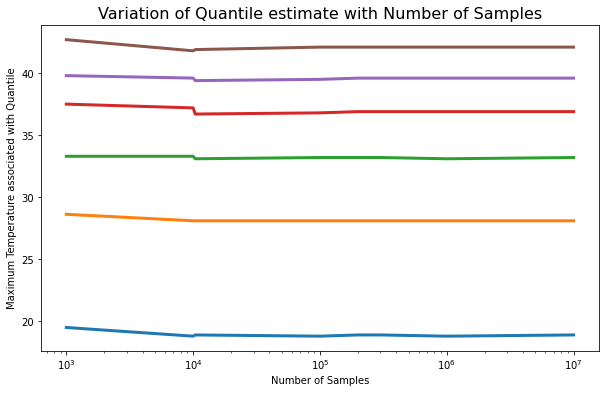

In [5]:
# plot the results, and and ensure the values converge to a single number
plt.figure(figsize=(10,6))
plt.semilogx(nsamps,qvals,lw=3)
plt.xlabel('Number of Samples')
plt.ylabel('Maximum Temperature associated with Quantile')
plt.title('Variation of Quantile estimate with Number of Samples',fontsize=16)
plt.show()

In [6]:
print(np.round(np.diff(qvals,axis=0),3))

[[-0.7   -0.525  0.    -0.305 -0.198 -0.899]
 [ 0.1    0.    -0.2   -0.495 -0.202  0.1  ]
 [-0.1    0.     0.1    0.095  0.1    0.199]
 [ 0.1    0.     0.     0.1    0.1    0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [-0.1    0.    -0.1    0.     0.     0.   ]
 [ 0.1    0.     0.1    0.     0.     0.   ]]


The quantile values converge after ~1e5 (one hundred thousand) samples to the order of our precision (which is higher than the precision of the query observations). This implies that the sampling method uses a large enough number to reproduce the quantities of the underlying distribution, at large scale for the whole domain. At smaller scale or a given geolocation with fewer outcomes/smaller maximum temperature range than the whole domain, we would expect this resampling to converge faster.

Accordingly, this method is used going forward in our attribution analyses with ```N=100_000``` samples.

# Create Single Pooled Counterfactual Output File

We have created a set of pooled counterfactual distributions and stored them alongside each model's bias-adjusted natural distribution, which enables comparison, etc. in this notebook.

Next, let's create a single file that has stores a resampled set of values from the pooled counterfactual distribution, for use throughout the remainder of our attribution analysis.

In [7]:
# define the number of samples we will take at each location,
# given the sensitivity found above:
N=100_000

In [8]:
# loop over the months
for mi in months:
    
    # load each month's pooled data
    mon_zarrname='pooledCF_mon'+str(mi).zfill(2)+'.zarr'
    ds_mi=util.load_zarr_local(pooled_loadpath,mon_zarrname)
    # grab the CF distribution we need
    CF_pooled=ds_mi[pooledvarname].load()
    del ds_mi
    
    # resample the distribution over space N times
    CF_resample=xr.apply_ufunc(
                util.randomly_sample_histogram,
                CF_pooled,
                kwargs=dict(N=N,bins=CF_pooled[binkey]),
                input_core_dims=[
                    [binkey],
                ],
                output_core_dims=[
                    ['samples'],
                ],
                vectorize=True
            )
    
    # store the result
    store = s3fs.S3Map(root='s3://gridded-data-dev/CMIP5_resample/'+monzarr,
                       s3=s3fs.S3FileSystem(), check=False)
    encoding = {CF_resample.name: {'compressor':zarr.Blosc(cname='zstd', clevel=3)}}
    CF_resample.to_dataset().to_zarr(store=store, encoding=encoding, consolidated=True, mode='w')
    
    # clean up
    del CF_pooled, CF_resample
    
    # tell the user where we are
    print('Completed resampling, month=='+str(mi))


Completed resampling, month==1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-a60199e0abee>", line 12, in <module>
    CF_resample=xr.apply_ufunc(
  File "/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/xarray/core/computation.py", line 1165, in apply_ufunc
    return apply_dataarray_vfunc(
  File "/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/xarray/core/computation.py", line 290, in apply_dataarray_vfunc
    result_var = func(*data_vars)
  File "/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/xarray/core/computation.py", line 733, in apply_variable_ufunc
    result_data = func(*input_data)
  File "/home/dgilford/.conda/envs/att/lib/python3.9/site-packages/numpy/lib/function_base.py", line 2113, in __call__
    return self._vectorize_call(func=func, args=vargs)
  File "/home/dgilford/.conda/e

TypeError: object of type 'NoneType' has no len()

In [9]:
del CF_resample